In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files


uploaded = files.upload()

Saving sales_data_sample.csv to sales_data_sample.csv


In [18]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['sales_data_sample.csv']), encoding='latin1')

In [19]:
df.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

In [22]:
def feat_eng(x:pd.DataFrame)->pd.DataFrame:
    df['DAYOFWEEK'] = pd.to_datetime(df['ORDERDATE']).dt.dayofweek.fillna(-1).astype(int)
    return df

num_cols = ['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER', 'SALES',
           'QTR_ID', 'MONTH_ID', 'YEAR_ID', 'DAYOFWEEK']
ord_cols = ['DEALSIZE', 'TERRITORY', 'STATUS']
ohe_cols = ['PRODUCTLINE', 'ADDRESSLINE2']

preprocessor = Pipeline(steps=[
    ('feat-eng', FunctionTransformer(feat_eng)),
    ('encoder', ColumnTransformer(transformers=[
        ('ordinal encoder', OrdinalEncoder(), ord_cols),
        ('one hot  encoder', OneHotEncoder(), ohe_cols),
        ('passthrough', 'passthrough', num_cols)
    ])),
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
])

preprocessor.fit(df)

Pipeline(steps=[('feat-eng',
                 FunctionTransformer(func=<function feat_eng at 0x7d95b3d41b40>)),
                ('encoder',
                 ColumnTransformer(transformers=[('ordinal encoder',
                                                  OrdinalEncoder(),
                                                  ['DEALSIZE', 'TERRITORY',
                                                   'STATUS']),
                                                 ('one hot  encoder',
                                                  OneHotEncoder(),
                                                  ['PRODUCTLINE',
                                                   'ADDRESSLINE2']),
                                                 ('passthrough', 'passthrough',
                                                  ['ORDERNUMBER',
                                                   'QUANTITYORDERED',
                                                   'PRICEEACH',
                                                   'ORDERLINENUMBER', 'SALES',
                                                   'QTR_ID', 'MONTH_ID',
                                                   'YEAR_ID', 'DAYOFWEEK'])])),
                ('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [23]:
X = preprocessor.transform(df)

In [25]:
from sklearn.cluster import KMeans

In [75]:
inertia = []
MAX_CLUSTERS=70

for i in range(1, MAX_CLUSTERS):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

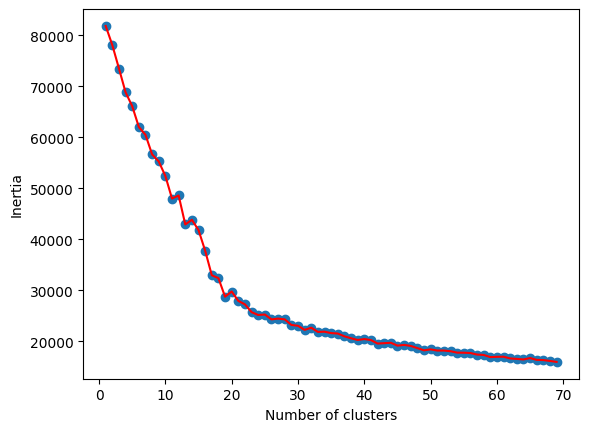

In [76]:
plt.plot(range(1, MAX_CLUSTERS), inertia, color='r')
plt.scatter(range(1, MAX_CLUSTERS), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [94]:
k = 15

In [95]:
clusters = KMeans(n_clusters=k).fit_predict(X)

In [96]:
clusters

array([5, 5, 5, ..., 3, 3, 3], dtype=int32)

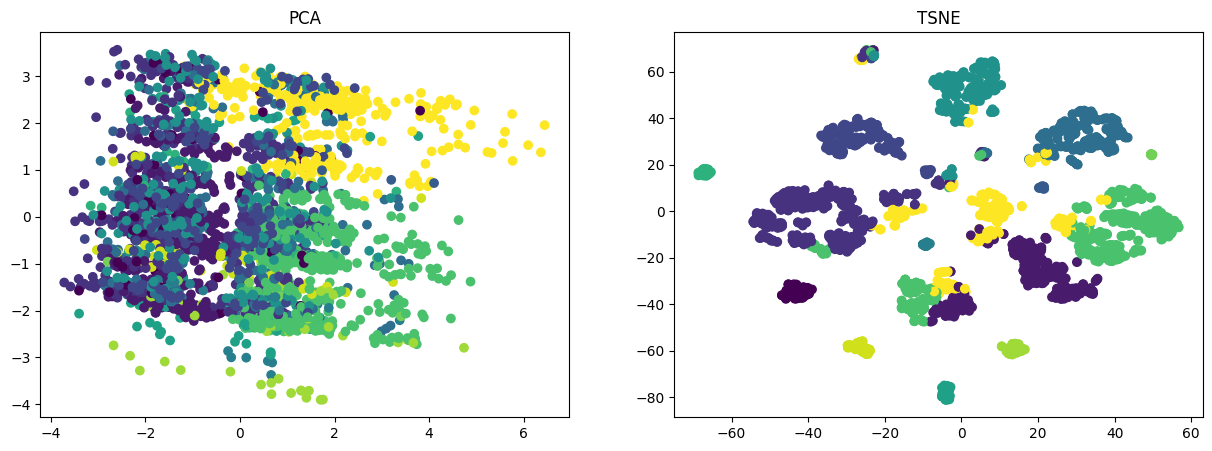

In [99]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca=pca.fit_transform(X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(X_pca[:,0], X_pca[:,1], c=clusters)
ax[0].set_title('PCA')

ax[1].scatter(X_tsne[:,0], X_tsne[:,1], c=clusters)
ax[1].set_title('TSNE')

plt.show()

In [97]:
import plotly.graph_objects as go

tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X)

x = X_tsne[:,0]
y = X_tsne[:,1]
z = X_tsne[:,2]

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=clusters,
        opacity=0.8,
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='X Axis',
                    yaxis_title='Y Axis',
                    zaxis_title='Z Axis'),
                  title="3D Scatter Plot")

fig.show()